# **Assignment-3:**

**Name:** Pavan Pandya

**Email:** pnpandya@iu.edu

## **Import Libraries:**

In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import pickle
from itertools import combinations
import IPython.display as ipd
import librosa
from sklearn.metrics import accuracy_score
from typing import List, Tuple
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

### **Setup:**

In [2]:
# # Input data files are available in the read-only "../input/" directory
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [3]:
# Define the directory paths
model_dir = '/kaggle/working/model'
output_dir = '/kaggle/working/output'

# Function to check and create directory
def create_directory(directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        print(f"Directory created: {directory_path}")
    else:
        print(f"Directory already exists: {directory_path}")
        
# Ensure the directory exists
create_directory(model_dir)
create_directory(output_dir)

Directory created: /kaggle/working/model
Directory created: /kaggle/working/output


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
import random

def set_seed(seed=42):
    # Set Python's random seed
    random.seed(seed)
    
    # Set NumPy's random seed
    np.random.seed(seed)
    
    # Set PyTorch's random seed for CPU
    torch.manual_seed(seed)
    
    # Set PyTorch's random seed for GPU (if using)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    
    # Ensure PyTorch operations are deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)

In [6]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist_train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 33991105.84it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 1017468.20it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 9445358.37it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 2907146.16it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## **Question-1:**

In [7]:
# 1. First, let's create our baseline network
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 1024)
        self.fc5 = nn.Linear(1024, 1024)
        self.fc6 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [8]:
# Function to evaluate model
def evaluate_model(model, test_loader):
    model = model.to(device)
    model.eval()
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == target).sum().item()
    return 100 * correct / total

In [9]:
# Function to train the model
def train_model(model, train_loader, test_loader, optimizer, epochs=30):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []  
    test_accuracies = []  

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0  

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()  

        # Average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)

        # Evaluation phase - using evaluate_model function
        test_accuracy = evaluate_model(model, test_loader)
        test_accuracies.append(test_accuracy)

        print(f'Epoch: [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return model, test_accuracies

In [10]:
class SVDCompressedNet(nn.Module):
    def __init__(self, baseline_model, D):
        super(SVDCompressedNet, self).__init__()
        self.D = D
        self.compressed_layers = []
        self.biases = []
        self.fc6 = baseline_model.fc6
        self.relu = nn.ReLU()

        # Get biases and compute SVD for each layer directly
        for i, layer in enumerate([baseline_model.fc1, baseline_model.fc2, baseline_model.fc3, baseline_model.fc4, baseline_model.fc5]):
            self.biases.append(getattr(baseline_model, f'fc{i+1}').bias.data)
            W = layer.weight.data
            
            # Adjust D for fc1 if necessary
            D_actual = 784 if D == 1024 and layer == baseline_model.fc1 else D
            
            U, S, V = torch.svd(W)
            U_compressed = U[:, :D_actual].to(device)
            S_compressed = torch.diag(S[:D_actual]).to(device)
            V_compressed = V[:, :D_actual].to(device)
            W_approx = U_compressed @ S_compressed @ V_compressed.T
            
            layer.weight.data = W_approx
            self.compressed_layers.append((U_compressed, S_compressed, V_compressed))

    def forward(self, x):
        x = x.view(-1, 784)
        for i, (U, S, V) in enumerate(self.compressed_layers):
            x = torch.mm(x, torch.mm(V, S).mm(U.t()))
            x = x + self.biases[i].unsqueeze(0)
            x = self.relu(x)
        x = self.fc6(x)
        return x

In [11]:
def count_baseline_parameters(model):
    """Count parameters in the baseline model using PyTorch's built-in parameter count."""
    return sum(p.numel() for p in model.parameters())

In [12]:
def count_compressed_parameters(D):
    """Count parameters in the compressed model based on the SVD decomposition structure."""
    # Input layer
    if D != 1024:
        input_layer_params = (784 * D) + D + (1024 * D) + 1024
    else:
        input_layer_params = (784 * 784) + 784 + (1024 * 784) + 1024

    # Hidden layers (4 layers)
    hidden_layers_params = 4 * ((1024 * D) + D + (1024 * D) + 1024)

    # Output layer (uncompressed)
    output_layer_params = (1024 * 10) + 10

    # Total parameters
    total = input_layer_params + hidden_layers_params + output_layer_params
    return total

In [13]:
q1_train_loader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
q1_test_loader = DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)

In [20]:
# Train baseline model
q1_baseline_model = BaselineNet()
q1_optimizer = optim.Adam(q1_baseline_model.parameters(), lr=0.001)
q1_baseline_model, q1_baseline_accuracies = train_model(q1_baseline_model, q1_train_loader, q1_test_loader, q1_optimizer, epochs=30)

Epoch: [1/30], Loss: 0.2739, Test Accuracy: 95.99%
Epoch: [2/30], Loss: 0.1279, Test Accuracy: 95.04%
Epoch: [3/30], Loss: 0.0915, Test Accuracy: 97.52%
Epoch: [4/30], Loss: 0.0736, Test Accuracy: 97.96%
Epoch: [5/30], Loss: 0.0614, Test Accuracy: 97.58%
Epoch: [6/30], Loss: 0.0470, Test Accuracy: 98.04%
Epoch: [7/30], Loss: 0.0413, Test Accuracy: 97.97%
Epoch: [8/30], Loss: 0.0378, Test Accuracy: 98.08%
Epoch: [9/30], Loss: 0.0315, Test Accuracy: 98.32%
Epoch: [10/30], Loss: 0.0314, Test Accuracy: 98.21%
Epoch: [11/30], Loss: 0.0297, Test Accuracy: 97.87%
Epoch: [12/30], Loss: 0.0228, Test Accuracy: 98.01%
Epoch: [13/30], Loss: 0.0293, Test Accuracy: 98.02%
Epoch: [14/30], Loss: 0.0222, Test Accuracy: 98.15%
Epoch: [15/30], Loss: 0.0207, Test Accuracy: 98.03%
Epoch: [16/30], Loss: 0.0178, Test Accuracy: 97.60%
Epoch: [17/30], Loss: 0.0235, Test Accuracy: 97.64%
Epoch: [18/30], Loss: 0.0225, Test Accuracy: 97.95%
Epoch: [19/30], Loss: 0.0167, Test Accuracy: 98.15%
Epoch: [20/30], Loss:

In [21]:
# Saving the q1_baseline_model
torch.save(q1_baseline_model.state_dict(), "/kaggle/working/model/q1_baseline_model.pth")

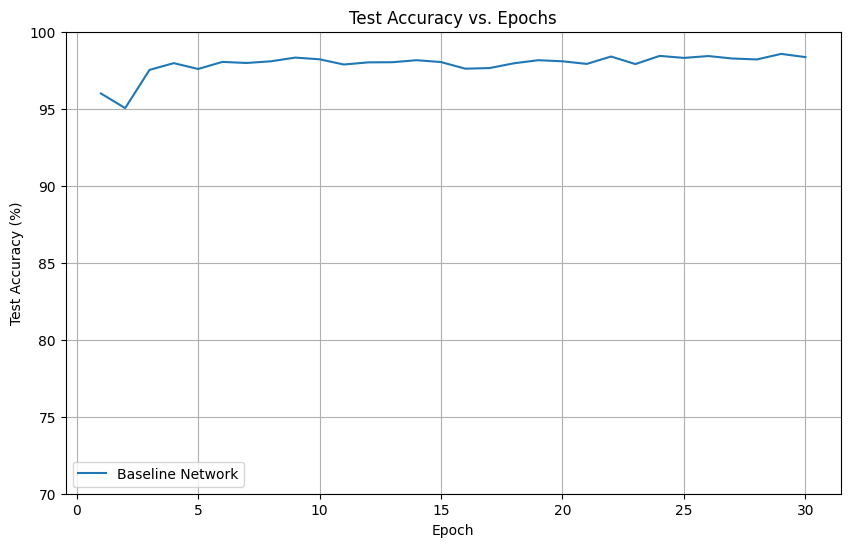

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), q1_baseline_accuracies, label='Baseline Network')
plt.title('Test Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.yticks([70, 75, 80, 85, 90, 95, 100])
plt.grid(True)
plt.legend()
plt.show()


In [23]:
# Function to evaluate and compare models
def evaluate_compression(baseline_model, train_loader, test_loader):
    # First, compute baseline parameters and accuracy
    baseline_params = count_baseline_parameters(baseline_model)
    q1_baseline_accuracy = evaluate_model(baseline_model, test_loader)
    
    print(f"Baseline - Parameters: {baseline_params:,}, Test Accuracy: {q1_baseline_accuracy:.2f}%")
    
    D_values = [10, 20, 50, 100, 200, 1024]
    compressed_params = []
    compressed_accuracies = []
    
    for D in D_values:
        # Reload the original baseline model weights before each SVD compression
        baseline_copy = BaselineNet().to(device)
        baseline_copy.load_state_dict(torch.load("/kaggle/working/model/q1_baseline_model.pth"))
        
        # Create the compressed model with the current D
        q1_compressed_model = SVDCompressedNet(baseline_copy, D).to(device)
            
        # Evaluate the compressed model
        q1_compressed_accuracy = evaluate_model(q1_compressed_model, test_loader)
        compressed_param_count = count_compressed_parameters(D)
        
        print(f"D: {D}, Compressed - Parameters: {compressed_param_count:,}, Test Accuracy: {q1_compressed_accuracy:.2f}%")
        
        # Append results to individual lists
        compressed_params.append(compressed_param_count)
        compressed_accuracies.append(q1_compressed_accuracy)
    
    # Return results in a structured way
    return D_values, compressed_params, compressed_accuracies, q1_baseline_accuracy

In [24]:
# Evaluate compression results
D_values, q1_compressed_params, q1_compressed_accuracies, q1_baseline_accuracy = evaluate_compression(q1_baseline_model, q1_train_loader, q1_test_loader)

Baseline - Parameters: 5,012,490, Test Accuracy: 98.35%
D: 10, Compressed - Parameters: 115,420, Test Accuracy: 27.99%
D: 20, Compressed - Parameters: 215,470, Test Accuracy: 83.84%
D: 50, Compressed - Parameters: 515,620, Test Accuracy: 97.94%
D: 100, Compressed - Parameters: 1,015,870, Test Accuracy: 98.19%
D: 200, Compressed - Parameters: 2,016,370, Test Accuracy: 98.26%
D: 1024, Compressed - Parameters: 9,826,330, Test Accuracy: 98.35%


In [27]:
# Save the q1_results
with open('/kaggle/working/output/q1_compressed_accuracies.json', 'w') as f:
    json.dump(q1_compressed_accuracies, f)

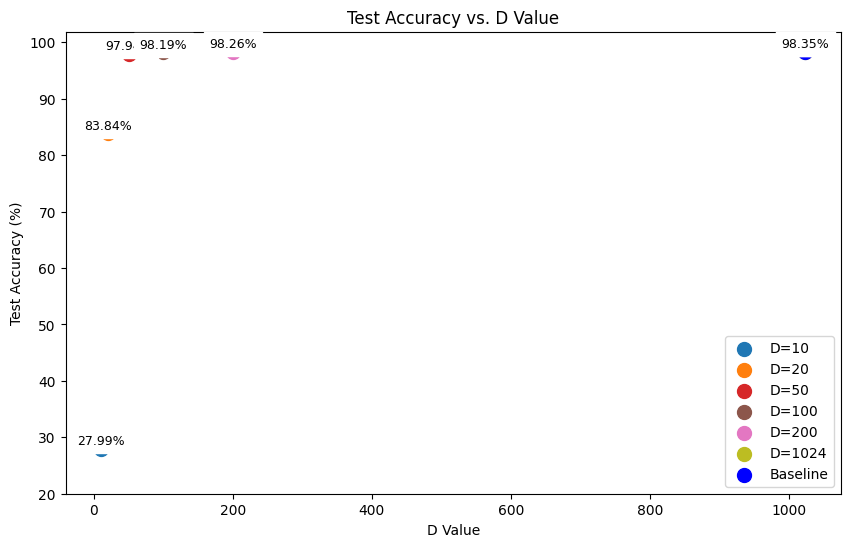

In [29]:
D_values = [10, 20, 50, 100, 200, 1024]

# Set up the plot
plt.figure(figsize=(10, 6))

# Define a color map for unique colors
colors = plt.colormaps['tab10']  

# Plot each compressed model with a unique color and legend based on D values
for i, D in enumerate(D_values):
    plt.scatter(D, q1_compressed_accuracies[i], color=colors(i / len(D_values)), label=f'D={D}', s=100)
    # Adjust the position and add a background color to the text for better readability
    plt.text(D, q1_compressed_accuracies[i] + 0.75, f"{q1_compressed_accuracies[i]:.2f}%", 
             ha='center', fontsize=9, backgroundcolor='white')

# Plot the baseline accuracy as a single point
plt.scatter(1024, q1_baseline_accuracy, color='blue', label='Baseline', s=100)
# Add text with a slight vertical offset above the baseline point
plt.text(1024, q1_baseline_accuracy + 0.75, f"{q1_baseline_accuracy:.2f}%", 
         ha='center', fontsize=9, backgroundcolor='white')

# Customize the plot
plt.title('Test Accuracy vs. D Value')
plt.xlabel('D Value')
plt.ylabel('Test Accuracy (%)')
plt.yticks([20, 30, 40, 50 , 60, 70, 80, 90, 100])
plt.legend(loc='lower right')
plt.show()

## **Question-2:**

In [30]:
q2_train_loader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
q2_test_loader = DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)

In [31]:
class FactorizedNet(nn.Module):
    def __init__(self, baseline_model, D=20):
        super(FactorizedNet, self).__init__()
        self.D = D
        
        # Initialize empty parameter lists
        self.U_layers = nn.ParameterList()
        self.V_layers = nn.ParameterList()
        self.biases = nn.ParameterList()
        
        # Initialize factorized weights from baseline model layers (SVD compression)
        for i, layer in enumerate([baseline_model.fc1, baseline_model.fc2, baseline_model.fc3, baseline_model.fc4, baseline_model.fc5]):
            # Get the weight matrix and bias from the baseline model
            W = layer.weight.data
            bias = layer.bias.data

            # Perform SVD on the weight matrix
            U, S, V = torch.svd(W)

            # Truncate to D dimensions
            U_init = U[:, :D].clone()
            V_init = V[:, :D].clone()
            S_init = S[:D].clone()

            # Create V @ diag(S) (for weight factorization)
            V_init = torch.mm(V_init, torch.diag(S_init))  # V(l)⊤ ← S(l)1:20,1:20 V(l)⊤:,1:20

            # Store U, V, and bias
            self.U_layers.append(nn.Parameter(U_init))
            self.V_layers.append(nn.Parameter(V_init))
            self.biases.append(nn.Parameter(bias))

        # Keep the last layer (fc6) unchanged
        self.fc6 = baseline_model.fc6
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 784) 
        
        # Apply the factorized layers
        for U, V, bias in zip(self.U_layers, self.V_layers, self.biases):
            # Compute V.T @ x first for efficiency
            x = torch.mm(x, V)  # V(l)⊤ @ x(l)
            # Then compute U @ (V.T @ x)
            x = torch.mm(x, U.t())  # U(l) @ (V(l)⊤ @ x(l))
            x = x + bias.unsqueeze(0)  # Add bias
            x = self.relu(x)  # Apply ReLU activation
        
        x = self.fc6(x)  # Last layer (fc6)
        return x

In [32]:
# Create the factorized model
q2_model = FactorizedNet(q1_baseline_model, D=20)
q2_optimizer = optim.Adam(q2_model.parameters(), lr=0.0001)

In [33]:
q2_model, q2_model_accuracies = train_model(q2_model, q2_train_loader, q2_test_loader, q2_optimizer, epochs=30)

Epoch: [1/30], Loss: 0.1058, Test Accuracy: 97.45%
Epoch: [2/30], Loss: 0.0603, Test Accuracy: 97.62%
Epoch: [3/30], Loss: 0.0478, Test Accuracy: 97.77%
Epoch: [4/30], Loss: 0.0403, Test Accuracy: 97.81%
Epoch: [5/30], Loss: 0.0342, Test Accuracy: 97.85%
Epoch: [6/30], Loss: 0.0294, Test Accuracy: 98.05%
Epoch: [7/30], Loss: 0.0254, Test Accuracy: 97.78%
Epoch: [8/30], Loss: 0.0249, Test Accuracy: 97.77%
Epoch: [9/30], Loss: 0.0213, Test Accuracy: 98.09%
Epoch: [10/30], Loss: 0.0197, Test Accuracy: 97.96%
Epoch: [11/30], Loss: 0.0197, Test Accuracy: 98.02%
Epoch: [12/30], Loss: 0.0171, Test Accuracy: 97.92%
Epoch: [13/30], Loss: 0.0152, Test Accuracy: 98.05%
Epoch: [14/30], Loss: 0.0167, Test Accuracy: 97.92%
Epoch: [15/30], Loss: 0.0130, Test Accuracy: 98.10%
Epoch: [16/30], Loss: 0.0126, Test Accuracy: 97.84%
Epoch: [17/30], Loss: 0.0137, Test Accuracy: 97.72%
Epoch: [18/30], Loss: 0.0127, Test Accuracy: 97.64%
Epoch: [19/30], Loss: 0.0130, Test Accuracy: 97.93%
Epoch: [20/30], Loss:

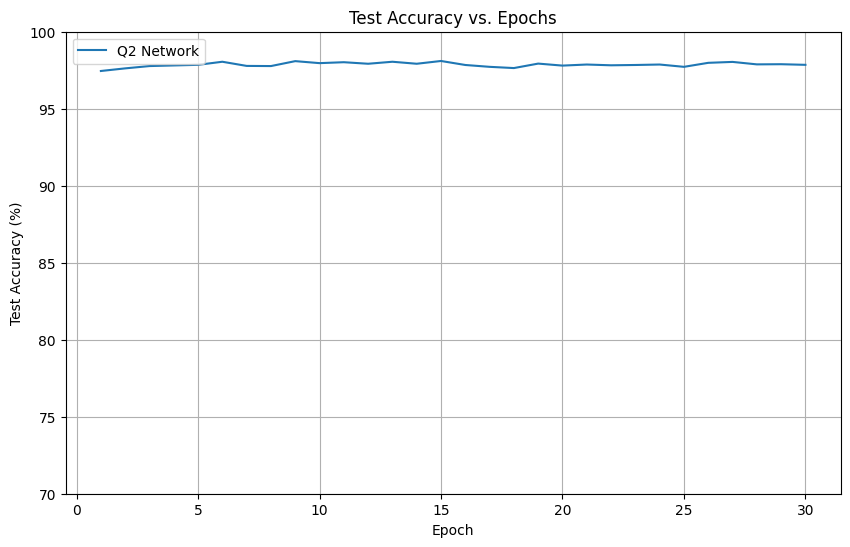

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), q2_model_accuracies, label='Q2 Network')
plt.title('Test Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.yticks([70, 75, 80, 85, 90, 95, 100])
plt.grid(True)
plt.legend()
plt.show()

In [35]:
q2_final_accuracy = evaluate_model(q2_model, q2_test_loader)

In [36]:
# D_values = [10, 20, 50, 100, 200, 1024]
q1_compressed_accuracies

[27.99, 83.84, 97.94, 98.19, 98.26, 98.35]

In [37]:
# Get the D=20 compressed accuracy from Q1 for comparison
d20_compressed_accuracy = q1_compressed_accuracies[1]

In [38]:
# Compare results
print("Results Comparison:\n")
print(f"Baseline Model Accuracy (D=1024): {q1_baseline_accuracy:.2f}%")
print(f"Compressed Model Accuracy (D=20): {d20_compressed_accuracy:.2f}%")
print(f"Finetuned Model (Factorized) Accuracy (D=20): {q2_final_accuracy:.2f}%")

Results Comparison:

Baseline Model Accuracy (D=1024): 98.35%
Compressed Model Accuracy (D=20): 83.84%
Finetuned Model (Factorized) Accuracy (D=20): 97.85%


In [39]:
# Saving the q2_model
torch.save(q2_model.state_dict(), "/kaggle/working/model/q2_model.pth")

## **Question-3:**

In [40]:
# Create data loaders
q3_train_loader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
q3_test_loader = DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)

In [41]:
class SVDTrainingNet(nn.Module):
    def __init__(self, baseline_model, D=20):
        super(SVDTrainingNet, self).__init__()
        
        self.baseline_model = baseline_model
        self.D = D

    def forward(self, x):
        x = x.view(-1, 784)  

        for layer in [self.baseline_model.fc1, self.baseline_model.fc2, self.baseline_model.fc3, self.baseline_model.fc4, self.baseline_model.fc5]:
            U, S, V = torch.svd(layer.weight.data)
            U_approx = U[:, :self.D]
            S_approx = torch.diag(S[:self.D])
            V_approx = V[:, :self.D]
            W_approx = U_approx @ S_approx @ V_approx.T  

            x = torch.relu(W_approx @ x.T + layer.bias.unsqueeze(1)).T

        x = x @ self.baseline_model.fc6.weight.T + self.baseline_model.fc6.bias

        return x

In [59]:
# Create model with SVD compression
q3_model = SVDTrainingNet(q1_baseline_model, D=20)
q3_optimizer = optim.Adam(q3_model.parameters(), lr=0.0001)

In [60]:
# Train model
q3_model, q3_model_accuracies = train_model(q3_model, q3_train_loader, q3_test_loader, q3_optimizer, epochs=30)

Epoch: [1/30], Loss: 0.2038, Test Accuracy: 95.71%
Epoch: [2/30], Loss: 0.1270, Test Accuracy: 96.08%
Epoch: [3/30], Loss: 0.1102, Test Accuracy: 96.42%
Epoch: [4/30], Loss: 0.1012, Test Accuracy: 96.51%
Epoch: [5/30], Loss: 0.0949, Test Accuracy: 96.66%
Epoch: [6/30], Loss: 0.0903, Test Accuracy: 96.74%
Epoch: [7/30], Loss: 0.0866, Test Accuracy: 96.76%
Epoch: [8/30], Loss: 0.0835, Test Accuracy: 96.80%
Epoch: [9/30], Loss: 0.0812, Test Accuracy: 96.91%
Epoch: [10/30], Loss: 0.0792, Test Accuracy: 96.97%
Epoch: [11/30], Loss: 0.0774, Test Accuracy: 97.00%
Epoch: [12/30], Loss: 0.0758, Test Accuracy: 96.98%
Epoch: [13/30], Loss: 0.0745, Test Accuracy: 97.07%
Epoch: [14/30], Loss: 0.0733, Test Accuracy: 97.12%
Epoch: [15/30], Loss: 0.0721, Test Accuracy: 97.16%
Epoch: [16/30], Loss: 0.0711, Test Accuracy: 97.19%
Epoch: [17/30], Loss: 0.0701, Test Accuracy: 97.26%
Epoch: [18/30], Loss: 0.0694, Test Accuracy: 97.29%
Epoch: [19/30], Loss: 0.0683, Test Accuracy: 97.33%
Epoch: [20/30], Loss:

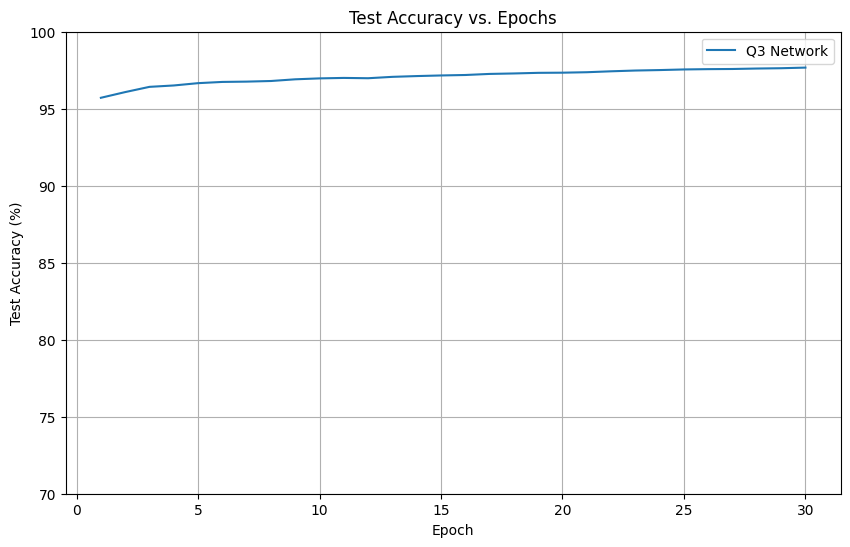

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), q3_model_accuracies, label='Q3 Network')
plt.title('Test Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.yticks([70, 75, 80, 85, 90, 95, 100])
plt.grid(True)
plt.legend()
plt.show()

In [62]:
q3_final_accuracy = evaluate_model(q3_model, q3_test_loader)

In [63]:
# Print results comparison
print("Results Comparison:\n")
print(f"Baseline Model Accuracy: {q1_baseline_accuracy:.2f}%")
print(f"Q1 Compressed Model Accuracy (D=20): {q1_compressed_accuracies[1]:.2f}%")
print(f"Q2 Finetuned Model Accuracy (D=20): {q2_final_accuracy:.2f}%")
print(f"Q3 SVD-during-training Accuracy (D=20): {q3_final_accuracy:.2f}%")

Results Comparison:

Baseline Model Accuracy: 98.35%
Q1 Compressed Model Accuracy (D=20): 83.84%
Q2 Finetuned Model Accuracy (D=20): 97.85%
Q3 SVD-during-training Accuracy (D=20): 97.67%


In [64]:
# Save the model
torch.save(q3_model.state_dict(), "/kaggle/working/model/q3_model.pth")

## **Question-4:**

In [6]:
# 1. Load the data
q4_base_path = "/kaggle/input/a3-q4-data"

with open(os.path.join(q4_base_path, 'trs.pkl'), 'rb') as f:
    trs_data = pickle.load(f)  # Shape: (500, 16180)
with open(os.path.join(q4_base_path,'tes.pkl'), 'rb') as f:
    tes_data = pickle.load(f)  # Shape: (200, 22631)

In [7]:
# Printing the shape of the data
print(f"Shape of training data: {trs_data.shape}")
print(f"Shape of testing data: {tes_data.shape}")

Shape of training data: (500, 16180)
Shape of testing data: (200, 22631)


In [8]:
# 2. Apply stft
def compute_stft(signal, target_size=(513, 32)):
    spec = np.abs(librosa.stft(signal, n_fft=1024, hop_length=512))
    if target_size[1] > spec.shape[1]:
        pad_width = ((0, 0), (0, target_size[1] - spec.shape[1]))
        spec = np.pad(spec, pad_width, mode='constant')
    return spec

In [9]:
# Modify the existing code to use this new function
trs_spec = np.array([compute_stft(signal, target_size=(513, 32)) for signal in trs_data])
tes_spec = np.array([compute_stft(signal, target_size=(513, 45)) for signal in tes_data])

print(f"Shape of training spectrograms: {trs_spec.shape}")
print(f"Shape of testing spectrograms: {tes_spec.shape}")

Shape of training spectrograms: (500, 513, 32)
Shape of testing spectrograms: (200, 513, 45)


In [10]:
class SpeakerVerificationDataset(Dataset):
    def __init__(self, spectrograms, speakers_per_batch=10, samples_per_speaker=10, pairs_per_speaker=45):
        """
        Args:
            spectrograms: Array of spectrograms (N, 513, T) where T can be 32 or 45
            speakers_per_batch: Number of spectrograms per speaker
            samples_per_speaker: Number of samples for each speaker
            pairs_per_speaker: Number of positive/negative pairs to generate per speaker
        """
        self.spectrograms = spectrograms
        self.speakers_per_batch = speakers_per_batch
        self.samples_per_speaker = samples_per_speaker
        self.pairs_per_speaker = pairs_per_speaker
        
        # Organize data by speaker
        self.speaker_data = [
            spectrograms[i:i+samples_per_speaker] 
            for i in range(0, len(spectrograms), samples_per_speaker)
        ]
        
        # Generate pairs and labels
        self.pairs, self.labels = self._create_pairs()
        
        print(f"Created dataset with {len(self.pairs)} pairs")

    def _get_positive_pairs(self, speaker_samples):
        """Generate positive pairs from same speaker"""
        all_pairs = list(combinations(speaker_samples, 2))
        num_pairs = min(self.pairs_per_speaker, len(all_pairs))
        return random.sample(all_pairs, num_pairs)

    def _get_negative_pairs(self, speaker_samples):
        """Generate negative pairs from different speakers"""
        other_speakers = [s for s in self.speaker_data if not np.array_equal(s, speaker_samples)]
        negative_pairs = []
        
        for _ in range(self.pairs_per_speaker):
            utterance1 = random.choice(speaker_samples)
            other_speaker = random.choice(other_speakers)
            utterance2 = random.choice(other_speaker)
            negative_pairs.append((utterance1, utterance2))
        
        return negative_pairs

    def _create_pairs(self):
        """Create all pairs and labels"""
        all_pairs = []
        all_labels = []
        
        for speaker_samples in self.speaker_data:
            # Get positive and negative pairs
            positive_pairs = self._get_positive_pairs(speaker_samples)
            negative_pairs = self._get_negative_pairs(speaker_samples)
            
            # Extend pairs and labels
            all_pairs.extend(positive_pairs + negative_pairs)
            all_labels.extend([1] * len(positive_pairs) + [0] * len(negative_pairs))
        
        return np.array(all_pairs), np.array(all_labels)

    def __len__(self):
        """Return the total number of pairs"""
        return len(self.pairs)

    def __getitem__(self, idx):
        """Get a pair of spectrograms and their label"""
        # Convert to torch tensors
        spectrogram1 = torch.tensor(self.pairs[idx][0], dtype=torch.float32)
        spectrogram2 = torch.tensor(self.pairs[idx][1], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        return spectrogram1, spectrogram2, label

In [11]:
def get_dataloaders(trs_spec, tes_spec, batch_size=32):
    """
    Create train, validation, and test dataloaders
    """
    # Calculate number of speakers
    num_speakers = len(trs_spec) // 10
    num_validation_speakers = int(0.2 * num_speakers)
    
    # Create indices for all speakers
    all_indices = np.arange(len(trs_spec))
    speaker_indices = all_indices.reshape(-1, 10)  # Reshape to (num_speakers, 10)
    
    # Randomly shuffle speakers
    np.random.shuffle(speaker_indices)
    
    # Split into train and validation
    val_indices = speaker_indices[:num_validation_speakers].flatten()
    train_indices = speaker_indices[num_validation_speakers:].flatten()
    
    print(f"Train speakers: {len(train_indices)//10}, Validation speakers: {len(val_indices)//10}")
    
    # Create datasets
    train_dataset = SpeakerVerificationDataset(trs_spec[train_indices])
    val_dataset = SpeakerVerificationDataset(trs_spec[val_indices])
    test_dataset = SpeakerVerificationDataset(tes_spec)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [12]:
q4_train_loader, q4_val_loader, q4_test_loader = get_dataloaders(trs_spec, tes_spec, batch_size=32)

Train speakers: 40, Validation speakers: 10
Created dataset with 3600 pairs
Created dataset with 900 pairs
Created dataset with 1800 pairs


In [13]:
# Verify the data
for batch_idx, (spec1, spec2, labels) in enumerate(q4_train_loader):
    print(f"Batch {batch_idx}")
    print(f"Spectrogram 1 shape: {spec1.shape}")
    print(f"Spectrogram 2 shape: {spec2.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch 0
Spectrogram 1 shape: torch.Size([32, 513, 32])
Spectrogram 2 shape: torch.Size([32, 513, 32])
Labels shape: torch.Size([32])


In [14]:
# Verify the data
for batch_idx, (spec1, spec2, labels) in enumerate(q4_test_loader):
    print(f"Batch {batch_idx}")
    print(f"Spectrogram 1 shape: {spec1.shape}")
    print(f"Spectrogram 2 shape: {spec2.shape}")
    print(f"Labels shape: {labels.shape}")
    break

Batch 0
Spectrogram 1 shape: torch.Size([32, 513, 45])
Spectrogram 2 shape: torch.Size([32, 513, 45])
Labels shape: torch.Size([32])


In [15]:
class SiameseGRUNetwork(nn.Module):
    def __init__(self, input_size=513, hidden_size=512, num_layers=2):
        super(SiameseGRUNetwork, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        x1 = x1.permute(0, 2, 1) 
        x2 = x2.permute(0, 2, 1)
        
        _, embedding1 = self.gru(x1)  
        _, embedding2 = self.gru(x2)
        
        embedding1 = embedding1[-1]  
        embedding2 = embedding2[-1]
        
        # Compute inner product and sigmoid
        inner_product = torch.sum(embedding1 * embedding2, dim=1)
        out = self.sigmoid(inner_product)
        
        return out

In [16]:
def evaluate_q4_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for spec1, spec2, labels in val_loader:
            spec1, spec2, labels = spec1.to(device), spec2.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(spec1, spec2)
            loss = criterion(outputs.squeeze(), labels)
            
            # Calculate metrics
            val_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    
    return val_loss, val_acc

In [17]:
def train_q4_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    best_val_acc = 0.0
    
    # Lists to store metrics for each epoch
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        
        for spec1, spec2, labels in train_loader:
            spec1, spec2, labels = spec1.to(device), spec2.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(spec1, spec2)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            # Calculate metrics
            train_loss += loss.item()
            predicted = (outputs.squeeze() > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        # Calculate average training metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = correct / total
        
        # Evaluate on validation set
        epoch_val_loss, epoch_val_acc = evaluate_q4_model(model, val_loader, criterion, device)
        
        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)
        
        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{epochs}] Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc*100:.4f}, Vali Acc: {epoch_val_acc*100:.4f}')
        
        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), '/kaggle/working/model/q4_best_siamese_model.pth')
    
    # Return final metrics
    return train_accs, val_accs, train_losses, val_losses

In [21]:
input_dim = 513  # STFT output dimension
hidden_size = 128
q4_model = SiameseGRUNetwork(input_dim, hidden_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(q4_model.parameters(), lr=0.00001)

In [22]:
q4_train_acc, q4_val_acc, q4_train_losses, q4_val_losses = train_q4_model(model=q4_model,train_loader=q4_train_loader,val_loader=q4_val_loader,criterion=criterion,optimizer=optimizer,device=device,epochs=30)

Epoch [1/30] Loss: 0.8640, Train Acc: 49.0833, Vali Acc: 49.3333
Epoch [2/30] Loss: 0.7470, Train Acc: 51.6111, Vali Acc: 51.0000
Epoch [3/30] Loss: 0.7209, Train Acc: 53.8056, Vali Acc: 51.8889
Epoch [4/30] Loss: 0.6974, Train Acc: 55.3889, Vali Acc: 52.7778
Epoch [5/30] Loss: 0.6769, Train Acc: 57.0556, Vali Acc: 55.2222
Epoch [6/30] Loss: 0.6575, Train Acc: 59.8333, Vali Acc: 57.0000
Epoch [7/30] Loss: 0.6399, Train Acc: 61.6389, Vali Acc: 57.3333
Epoch [8/30] Loss: 0.6236, Train Acc: 63.6389, Vali Acc: 58.7778
Epoch [9/30] Loss: 0.6081, Train Acc: 65.5556, Vali Acc: 59.3333
Epoch [10/30] Loss: 0.5936, Train Acc: 67.1667, Vali Acc: 60.3333
Epoch [11/30] Loss: 0.5797, Train Acc: 68.8611, Vali Acc: 60.7778
Epoch [12/30] Loss: 0.5657, Train Acc: 71.0000, Vali Acc: 61.3333
Epoch [13/30] Loss: 0.5539, Train Acc: 71.8611, Vali Acc: 61.1111
Epoch [14/30] Loss: 0.5429, Train Acc: 73.4444, Vali Acc: 62.4444
Epoch [15/30] Loss: 0.5294, Train Acc: 75.0278, Vali Acc: 63.0000
Epoch [16/30] Loss:

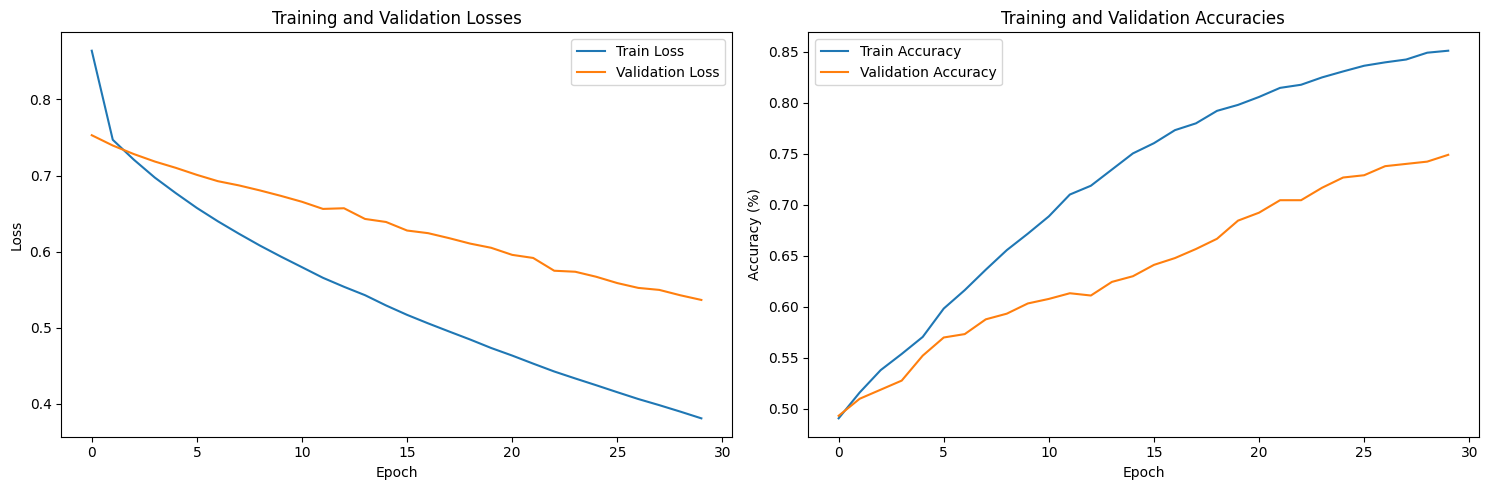

In [23]:
# Plot training progress
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(q4_train_losses, label='Train Loss')
plt.plot(q4_val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(q4_train_acc, label='Train Accuracy')
plt.plot(q4_val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Final test accuracy
q4_test_loss, q4_test_acc = evaluate_q4_model(q4_model, q4_test_loader, criterion, device)
print(f"Test Loss: {q4_test_loss:.4f}, Test Acc: {q4_test_acc*100:.2f}%")

Test Loss: 0.4497, Test Acc: 70.89%


## **Question-5:**

In [6]:
def process_audio(file_path):
    s, sr = librosa.load(file_path, sr=None)
    s_FT = librosa.stft(s, n_fft=1024, hop_length=512)
    S = np.abs(s_FT)
    return s_FT, sr, S

In [7]:
def get_unique_prefixes(folder_name):
    prefixes = set()
    base_path = "/kaggle/input/homework3/timit-homework/"
    for filename in os.listdir(os.path.join(base_path, folder_name)):
        if filename.endswith('.wav'):
            prefix = ''.join(char for char in filename[:3] if char.isalpha())
            prefixes.add(prefix)
    return prefixes

# Paths to the folders
folders = ["tr","te", "v"]

# Check unique prefixes in each folder
for folder in folders:
    unique_prefixes = get_unique_prefixes(folder)
    print(f"Unique prefixes in {folder}: {unique_prefixes}")
    print()

Unique prefixes in tr: {'trn', 'trx', 'trs'}

Unique prefixes in te: {'tex'}

Unique prefixes in v: {'vn', 'vx', 'vs'}



In [8]:
def load_dataset(base_path):
    dataset = defaultdict(lambda: defaultdict(list))
    prefixes = {
        'tr': {'x': 'trx', 's': 'trs', 'n': 'trn'},
        'v': {'x': 'vx', 's': 'vs', 'n': 'vn'},
        'te': {'x': 'tex'}
    }

    for folder, prefix_dict in prefixes.items():
        folder_path = os.path.join(base_path, folder)
        files = os.listdir(folder_path)
        
        for file in sorted(files):
            for data_type, prefix in prefix_dict.items():
                if file.startswith(prefix):
                    file_path = os.path.join(folder_path, file)
                    dataset[folder][data_type].append(process_audio(file_path))
                    break

    return dataset

In [9]:
base_path="/kaggle/input/homework3/timit-homework"
dataset = load_dataset(base_path)

In [10]:
data_trx = dataset['tr']['x']
data_trs = dataset['tr']['s']
data_trn = dataset['tr']['n']
data_vx = dataset['v']['x']
data_vs = dataset['v']['s']
data_vn = dataset['v']['n']
data_te = dataset['te']['x']

In [11]:
print("Dataset Statistics:")
print("-" * 50)
print(f"Number of matrices: {len(data_trx)}")  # Should be 1,200
print(f"Number of rows in each matrix: {data_trx[0][2].shape[0]}") # Should be 513

Dataset Statistics:
--------------------------------------------------
Number of matrices: 1200
Number of rows in each matrix: 513


In [12]:
def prepare_q5_dataset(noisy, clean, noise):
    X = [data[2].T for data in noisy]

    # Ideal Binary Masks (IBM)
    Y = [(S[2] > N[2]).astype(float).T for S, N in zip(clean, noise)]

    max_len = max(x.shape[0] for x in X)

    X_padded = np.array([np.pad(x, ((0, max_len - x.shape[0]), (0, 0)), 'constant') for x in X])
    Y_padded = np.array([np.pad(y, ((0, max_len - y.shape[0]), (0, 0)), 'constant') for y in Y])

    return X_padded, Y_padded

In [13]:
# PyTorch Dataset class for loading audio data
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

In [14]:
q5_train_data = AudioDataset(*prepare_q5_dataset(data_trx, data_trs, data_trn))
q5_val_data = AudioDataset(*prepare_q5_dataset(data_vx, data_vs, data_vn))

In [15]:
# Create DataLoaders
q5_train_loader = DataLoader(q5_train_data, batch_size=10, shuffle=True, pin_memory=True)
q5_val_loader = DataLoader(q5_val_data, batch_size=10, shuffle=False, pin_memory=True)

In [16]:
# Print tensor shapes for verification
for batch_idx, (data, target) in enumerate(q5_train_loader):
    print("\nBatch tensor shapes:")
    print(f"Input batch: {data.shape}")  # Should be [10, T, 513]
    print(f"Target batch: {target.shape}")
    break


Batch tensor shapes:
Input batch: torch.Size([10, 178, 513])
Target batch: torch.Size([10, 178, 513])


In [17]:
def calculate_snr(clean_signal, denoised_signal):
    numerator = np.sum(clean_signal**2)
    denominator = np.sum((clean_signal - denoised_signal)**2) + 1e-20
    snr = 10 * np.log10(numerator / denominator)
    return snr

In [18]:
class SpeechDenoisingRNN(nn.Module):
    def __init__(self):
        super(SpeechDenoisingRNN, self).__init__()

        self.gru = nn.GRU(input_size=513, hidden_size=512, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2), 
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 513),
            nn.Sigmoid()
            )

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        return out

In [19]:
def validate_q5_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_snr = 0
    num_batches = len(val_loader)

    with torch.no_grad():
        for batch_idx, (noisy_spec, target_mask) in enumerate(val_loader):
            noisy_spec, target_mask = noisy_spec.to(device), target_mask.to(device)
            
            # Get model predictions (binary mask)
            predicted_mask = model(noisy_spec)
            
            # Calculate validation loss
            loss = criterion(predicted_mask, target_mask)
            total_loss += loss.item()
            
            # Calculate SNR in the spectrogram domain
            # Apply predicted mask to noisy spectrogram
            denoised_spec = predicted_mask * noisy_spec
            target_spec = target_mask * noisy_spec
            
            # Calculate SNR
            noise = denoised_spec - target_spec
            signal_power = torch.sum(target_spec ** 2)
            noise_power = torch.sum(noise ** 2)
            batch_snr = 10 * torch.log10(signal_power / noise_power)
            
            total_snr += batch_snr.item()
    
    avg_loss = total_loss / num_batches
    avg_snr = total_snr / num_batches
    
    return avg_loss, avg_snr

In [20]:
def train_q5_model(model, train_loader, val_loader, device, num_epochs=50):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(q5_model.parameters(), lr=0.00001)
    train_losses = []
    val_losses = []
    val_snrs = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        val_loss, val_snr = validate_q5_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_snrs.append(val_snr)
        
        # Print epoch summary
        print(f'Epoch: [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation SNR: {val_snr:.2f} dB')
        
        if val_snr > 10:
            print(f"SNR ({val_snr:.2f} dB) is better than Goal (10 dB)!")
    
    return train_losses, val_losses, val_snrs

In [21]:
# Initialize model
q5_model = SpeechDenoisingRNN().to(device)
print("\nModel Architecture:")
print(q5_model)


Model Architecture:
SpeechDenoisingRNN(
  (gru): GRU(513, 512, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=1024, out_features=513, bias=True)
    (7): Sigmoid()
  )
)


In [22]:
# Train the model
q5_train_losses, q5_val_losses, q5_val_snrs = train_q5_model(q5_model, q5_train_loader, q5_val_loader, device)

Epoch: [1/50], Training Loss: 0.2454, Validation Loss: 0.2302, Validation SNR: 2.96 dB
Epoch: [2/50], Training Loss: 0.1768, Validation Loss: 0.1481, Validation SNR: 3.02 dB
Epoch: [3/50], Training Loss: 0.1452, Validation Loss: 0.1447, Validation SNR: 3.05 dB
Epoch: [4/50], Training Loss: 0.1427, Validation Loss: 0.1427, Validation SNR: 3.12 dB
Epoch: [5/50], Training Loss: 0.1408, Validation Loss: 0.1410, Validation SNR: 3.20 dB
Epoch: [6/50], Training Loss: 0.1389, Validation Loss: 0.1391, Validation SNR: 3.33 dB
Epoch: [7/50], Training Loss: 0.1369, Validation Loss: 0.1376, Validation SNR: 3.35 dB
Epoch: [8/50], Training Loss: 0.1350, Validation Loss: 0.1353, Validation SNR: 3.45 dB
Epoch: [9/50], Training Loss: 0.1331, Validation Loss: 0.1332, Validation SNR: 3.51 dB
Epoch: [10/50], Training Loss: 0.1311, Validation Loss: 0.1307, Validation SNR: 3.63 dB
Epoch: [11/50], Training Loss: 0.1288, Validation Loss: 0.1279, Validation SNR: 3.74 dB
Epoch: [12/50], Training Loss: 0.1260, Va

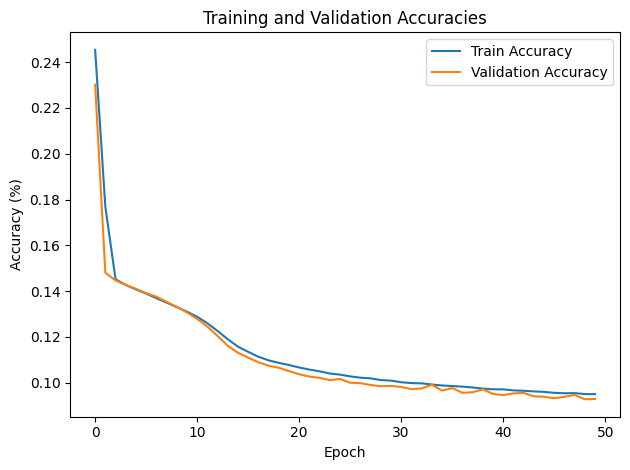

In [23]:
# Plot Accuracies
plt.plot(q5_train_losses, label='Train Accuracy')
plt.plot(q5_val_losses, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Calculate average SNR
average_snr = np.mean(q5_val_snrs)
print(f"Average Validation SNR: {average_snr:.2f} dB")

Average Validation SNR: 4.92 dB


In [28]:
def generate_denoised_magnitudes(data_te, model, device):
    # Initialize an empty list to store the denoised magnitudes
    denoised_test_mag = []

    # Loop over the noisy test magnitudes in the denoising dataset
    for _, _, noisy_test_mag in data_te:
        # Step 1: Transpose and convert noisy_test_mag to a PyTorch tensor of type float32
        noisy_test_tensor = torch.tensor(noisy_test_mag.T, dtype=torch.float32).to(device)
        
        # Step 2: Run the tensor through the denoising model and detach the result
        denoised_tensor = model(noisy_test_tensor).detach().cpu()
        
        # Step 3: Convert the tensor to a NumPy array and multiply element-wise by the transposed noisy_test_mag
        denoised_mag = denoised_tensor.numpy() * noisy_test_mag.T
        
        # Step 4: Append the denoised magnitude array to the list
        denoised_test_mag.append(denoised_mag)

    return np.array(denoised_test_mag, dtype="object")

In [29]:
denoised_test_mag = generate_denoised_magnitudes(data_te, q5_model, device)

In [30]:
noisy_test_audio = librosa.istft(data_te[0][2], hop_length=512)

In [31]:
ipd.Audio(noisy_test_audio, rate = data_te[0][1])

In [32]:
phase = data_te[0][0]/data_te[0][2]
denoised_test_audio = phase * denoised_test_mag[0].T
denoised_test_audio = librosa.istft(denoised_test_audio, hop_length=512)

In [33]:
ipd.Audio(denoised_test_audio, rate = data_te[0][1])